In [95]:
from __future__ import print_function

# Take sample of articles based on classification scores for org. science perspectives

@author: Jaren Haber, PhD<br>
@coauthors: Prof. Heather Haveman, UC Berkeley; Yoon Sung Hong, Wayfair<br>
@contact: Jaren.Haber@georgetown.edu<br>
@project: Computational Literature Review of Organizational Scholarship<br>
@repo: https://github.com/h2researchgroup/classification/<br>
@date: December 2020

'''
Uses classifiers trained on labeled articles (uses a perspective or not) to select a sample of articles (of given length) per perspective (cultural, relational, and demographic) for hand-labeling. Data source is full academic articles in sociology or management/org. behavior from JSTOR. For the first batch using this script, 90% of these selected articles are predicted to be of the minority class for that perspective, which is 'yes' for all three. The remaining 10% are from majority class, which are easier to predict in our skewed first batch of data. Future batches may use a more balanced sampling procedure. 
'''

## Initialize

In [136]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import re, csv, os
from datetime import date
from random import sample
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import time
from time import sleep
import random
random.seed(43)

stemmer = WordNetLemmatizer()

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import joblib
import math

import sys; sys.path.insert(0, "../preprocess/") # For loading functions from files in other directory
#from clean_text import stopwords_make, punctstr_make, unicode_make, apache_tokenize, clean_sentence_apache # for preprocessing text
from quickpickle import quickpickle_dump, quickpickle_load # custom scripts for quick saving & loading to pickle format
from text_to_file import write_textlist, read_text # custom scripts for reading and writing text lists to .txt files

In [2]:
######################################################
# Define filepaths
######################################################

thisday = date.today().strftime("%m%d%y")

cwd = os.getcwd()
root = str.replace(cwd, 'classification/modeling', '')

# Directory for prepared data and trained models: save files here
data_fp = root + 'classification/data/'
model_fp = root + 'classification/models/'
prepped_fp = root + 'models_storage/preprocessed_texts/'

# Current article lists
article_list_fp = data_fp + 'filtered_length_index.csv' # Filtered index of research articles
article_paths_fp = data_fp + 'filtered_length_article_paths.csv' # List of article file paths
article_names_fp = data_fp + 'filtered_length_article_names.xlsx' # Filtered list of article names and general data, sorted by journal then article name

# Path to ALL JSTOR preprocessed text
all_prepped_fp = prepped_fp + 'filtered_preprocessed_texts_65365_022421.pkl'

# Path to predictions for all perspectives
predicted_fp = model_fp + 'predictions_MLP_65365_022621.pkl' # 'predictions_RF_65365_121620.pkl'

# Per-article metadata with year and URL info
meta_fp = root + 'dictionary_methods/code/metadata_combined.h5' 

n_sample = 50 # how many to sample per perspective

In [121]:
######################################################
# API Setup
######################################################

import woslite_client
from woslite_client.rest import ApiException
from pprint import pprint

# Configure API key authorization: key
configuration = woslite_client.Configuration()
configuration.api_key['X-ApiKey'] = '9f393dd2ff6166b38de7568d039ab12d51a5c726'

# Create an instance of the API class
integration_api_instance = woslite_client.IntegrationApi(woslite_client.ApiClient(configuration))
search_api_instance = woslite_client.SearchApi(woslite_client.ApiClient(configuration))
database_id = 'WOK'  # str | Database to search. Must be a valid database ID, one of the following: BCI/BIOABS/BIOSIS/CCC/DCI/DIIDW/MEDLINE/WOK/WOS/ZOOREC. WOK represents all databases.

## Load & merge data

In [3]:
# Read in metadata file
df_meta = pd.read_hdf(meta_fp)
df_meta.reset_index(drop=False, inplace=True) # extract file name from index

# For merging purposes, get ID alone from file name, e.g. 'journal-article-10.2307_2065002' -> '10.2307_2065002'
df_meta['edited_filename'] = df_meta['file_name'].apply(lambda x: x[16:]) 
df_meta = df_meta[["edited_filename", "article_name", "jstor_url", "abstract", "journal_title", "given_names", "primary_subject", "year", "type"]] # keep only relevant columns

df_meta.head()

,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year,type
0,10.2307_4167860,Cross-Dialectal Variation in Arabic: Competing...,https://www.jstor.org/stable/4167860,Most researchers of Arabic sociolinguistics as...,Language in Society,None,Other,1979,research-article
1,10.2307_2578336,None,https://www.jstor.org/stable/2578336,None,Social Forces,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1983,book-review
2,10.2307_2654760,None,https://www.jstor.org/stable/2654760,None,Contemporary Sociology,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1998,book-review
3,10.2307_43242281,editor's note: A KNIGHT'S TALE,https://www.jstor.org/stable/43242281,None,Corporate Knights,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Other,2005,misc
4,10.2307_42862018,None,https://www.jstor.org/stable/42862018,None,Social Science Quarterly,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1985,book-review


In [4]:
df_pred = quickpickle_load(predicted_fp)
df_pred

,file_name,prediction_cult,prediction_cult_prob_yes,prediction_cult_prob_no,prediction_relt,prediction_relt_prob_yes,prediction_relt_prob_no,prediction_demog,prediction_demog_prob_yes,prediction_demog_prob_no,prediction_orgs,prediction_orgs_prob_yes,prediction_orgs_prob_no
0,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,8.341800e-01,1.658200e-01,yes,9.999984e-01,1.609325e-06,no,6.852263e-09,1.000000e+00,yes,1.000000,0.000000
1,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,9.999993e-01,7.152557e-07,yes,9.410939e-01,5.890614e-02,yes,1.000000e+00,0.000000e+00,yes,1.000000,0.000000
2,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,8.582058e-01,1.417942e-01,yes,1.000000e+00,0.000000e+00,no,1.322212e-08,1.000000e+00,yes,1.000000,0.000000
3,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,9.999998e-01,2.384186e-07,no,5.699001e-09,1.000000e+00,no,2.465694e-08,1.000000e+00,yes,1.000000,0.000000
4,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,9.999982e-01,1.788139e-06,yes,9.999682e-01,3.182888e-05,no,3.142881e-07,9.999997e-01,yes,1.000000,0.000000
5,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,1.000000e+00,0.000000e+00,no,1.922251e-09,1.000000e+00,no,1.701754e-09,1.000000e+00,yes,1.000000,0.000000
6,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,9.999995e-01,5.364418e-07,no,1.509981e-09,1.000000e+00,yes,9.999974e-01,2.563000e-06,yes,1.000000,0.000000
7,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,7.782824e-01,2.217176e-01,yes,9.999961e-01,3.933907e-06,no,1.382176e-07,9.999999e-01,yes,1.000000,0.000000
8,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,9.999917e-01,8.344650e-06,yes,6.257159e-01,3.742841e-01,no,4.969013e-07,9.999995e-01,yes,1.000000,0.000000
9,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,5.629873e-01,4.370127e-01,yes,8.063582e-01,1.936418e-01,no,2.138670e-10,1.000000e+00,yes,1.000000,0.000000


In [5]:
# Read in filtered index
df = pd.read_csv(article_list_fp, low_memory=False, header=None, names=["file_name"])
df['edited_filename'] = df['file_name'].apply(lambda x: x[16:]) # New col with only article ID

# Read predictions using latest models
df_pred = quickpickle_load(predicted_fp)

# For consistency across data sources, rename absolute file path to 'file_path' and create shorter 'file_name'
df_pred['file_path'] = df_pred['file_name'] # rename for consistency across files
df_pred['file_name'] = df_pred['file_name'].str.replace(
    '/vol_b/data/jstor_data/ocr/', '').str.replace('.txt', '') # remove folders + file suffix

# Merge meta data, predictions into articles list DF
df = pd.merge(df, df_meta, how='left', on='edited_filename') # meta data
df = pd.merge(df, df_pred, how='right', on='file_name') # predictions

# Show all columns in resulting DF
print("All columns:\n", list(df))
print()

print("Rows, cols in data:", df.shape)

df.head()

All columns:
 ['file_name', 'edited_filename', 'article_name', 'jstor_url', 'abstract', 'journal_title', 'given_names', 'primary_subject', 'year', 'type', 'prediction_cult', 'prediction_cult_prob_yes', 'prediction_cult_prob_no', 'prediction_relt', 'prediction_relt_prob_yes', 'prediction_relt_prob_no', 'prediction_demog', 'prediction_demog_prob_yes', 'prediction_demog_prob_no', 'prediction_orgs', 'prediction_orgs_prob_yes', 'prediction_orgs_prob_no', 'file_path']

Rows, cols in data: (65365, 23)


,file_name,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year,type,...,prediction_relt,prediction_relt_prob_yes,prediction_relt_prob_no,prediction_demog,prediction_demog_prob_yes,prediction_demog_prob_no,prediction_orgs,prediction_orgs_prob_yes,prediction_orgs_prob_no,file_path
0,journal-article-10.2307_2065002,10.2307_2065002,Toward More Cumulative Inquiry,https://www.jstor.org/stable/2065002,None,Contemporary Sociology,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1978,research-article,...,no,0.068754,0.931246,no,0.033144,0.966856,no,0.002368,0.997632,/vol_b/data/jstor_data/ocr/journal-article-10....
1,journal-article-10.2307_3380821,10.2307_3380821,An Analysis of an Incentive Sick Leave Policy ...,https://www.jstor.org/stable/3380821,Local health departments are under tremendous ...,Public Productivity & Management Review,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Management & Organizational Behavior,1986,research-article,...,no,0.099212,0.900788,yes,0.938169,0.061831,yes,0.893345,0.106655,/vol_b/data/jstor_data/ocr/journal-article-10....
2,journal-article-10.2307_2095822,10.2307_2095822,Local Friendship Ties and Community Attachment...,https://www.jstor.org/stable/2095822,This study presents a multilevel empirical tes...,American Sociological Review,"[Alice O., Peter, W. Erwin, Bert, Robert W., C...",Sociology,1983,research-article,...,yes,0.872496,0.127504,no,0.296735,0.703265,yes,0.521677,0.478323,/vol_b/data/jstor_data/ocr/journal-article-10....
3,journal-article-10.2307_40836133,10.2307_40836133,Knowledge Transfer within the Multinational Fi...,https://www.jstor.org/stable/40836133,This paper examines the process of knowledge t...,MIR: Management International Review,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Management & Organizational Behavior,2005,research-article,...,no,0.024153,0.975847,no,0.025947,0.974053,no,0.000218,0.999782,/vol_b/data/jstor_data/ocr/journal-article-10....
4,journal-article-10.2307_2579666,10.2307_2579666,Dynamics of Labor Market Segmentation in Polan...,https://www.jstor.org/stable/2579666,Research in the early 1980s showed that indust...,Social Forces,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1990,research-article,...,no,0.471403,0.528597,no,0.001887,0.998113,no,0.007546,0.992454,/vol_b/data/jstor_data/ocr/journal-article-10....


## Correct publication year using API

In [172]:
def get_year_wos(title):
    '''
    Gets publication year for article using title, using the Scholarly API (which uses Google Scholar). 
    
    Docs: https://github.com/Clarivate-SAR/woslite_py_client
    
    Args:
        title (str): full title, e.g., 'The Collective Strategy Framework: An Application to Competing Predictions of Isomorphism'
        
    Returns:
        pub_year (int): year article was published, in four digits (i.e., `19xx` or `20xx`)
    '''
    
    # Configure query
    title = title.replace("'", "") # remove apostrophes (confuses parser)
    usr_query = f"TS=({title})" # str | User query for requesting data, ex: TS=(cadmium). The query parser will return errors for invalid queries.
    count = 1  # int | Number of records returned in the request
    first_record = 1  # int | Specific record, if any within the result set to return. Cannot be less than 1 and greater than 100000.
    lang = 'en'  # str | Language of search. This element can take only one value: en for English. If no language is specified, English is passed by default. (optional)
    sort_field = 'PY+D'  # str | Order by field(s). Field name and order by clause separated by '+', use A for ASC and D for DESC, ex: PY+D. Multiple values are separated by comma. (optional)
    
    try:
        # Find record(s) by user query
        api_response = search_api_instance.root_get(database_id, usr_query, count, first_record, lang=lang,
                                                                 sort_field=sort_field)
        
        # Get fields of interest from API response
        pub_year = api_response.data[0].source.published_biblio_year[0]
        pub_title = api_response.data[0].title.title[0]
        #print(f'API record found for: \t\t"{pub_title}"')
        
        sleep(random.randint(1500,3000)/100000) # random pause for politeness/to avoid getting blocked by API
        
        return pub_year, pub_title
        
    except Exception as e:
        #print("API failed to with error: \t%s" % e)
        return

In [171]:
# Test function
title_year_tups = [
    ("A Socio-instutionalist Critique of the 1990s' Reforms of the United Kingdom's National Health Service", 2002, 2002), 
    ("Deepening Our Commitment, Hitting the Streets: A Call to Action", 2001, 2001), 
    ("Linking Organizational Values to Relationships with External Constituents: A Study of Nonprofit Professional Theatres", 2000, 1995), 
    ("On the Foundations of Athenian Democracy: Marx's Paradox and Weber's Solution", 2000, 2000), 
    ("Consumption Caught in the 'Cash Nexus'", 2000, 2000), 
    ("Culture and Charisma: Outline of a Theory", 2000, 1971), 
    ("The Collective Strategy Framework: An Application to Competing Predictions of Isomorphism", 1988, 1984), 
    ("Windows of Opportunity: Temporal Patterns of Technological Adaptation in Organizations", 1994, 1986), 
    ("The Gentle Leviathan: Welfare and the Indian State", 1994, 1987)]

for title, true_year, jstor_year in title_year_tups:
    retrieved_year, _ = get_year_webofscience(title)
    print('JSTOR Title: \t\t\t"{}"'.format(title))
    print("Verified pub year: \t\t{}".format(str(true_year)))
    print("Pub year from Web of Science: \t{}".format(str(retrieved_year)))
    print("Pub year from JSTOR: \t\t{}".format(str(jstor_year)))
    print()

API failed to with error: 	list index out of range
JSTOR Title: 			"A Socio-instutionalist Critique of the 1990s' Reforms of the United Kingdom's National Health Service"
Verified pub year: 		2002
Pub year from Web of Science: 	None
Pub year from JSTOR: 		2002

API record found for: 		"Deepening our commitment, hitting the streets: A call to action"
JSTOR Title: 			"Deepening Our Commitment, Hitting the Streets: A Call to Action"
Verified pub year: 		2001
Pub year from Web of Science: 	2001
Pub year from JSTOR: 		2001

API record found for: 		"Linking organizational values to relationships with external constituents: A study of nonprofit professional theatres"
JSTOR Title: 			"Linking Organizational Values to Relationships with External Constituents: A Study of Nonprofit Professional Theatres"
Verified pub year: 		2000
Pub year from Web of Science: 	2000
Pub year from JSTOR: 		1995

API failed to with error: 	list index out of range
JSTOR Title: 			"On the Foundations of Athenian Democ

In [ ]:
# Implement best approach
df['year'].rename(columns={"year":"year_jstor"}, inplace=True) # rename 'year' column to differentiate
df['article_name'].rename(columns={"article_name":"article_name_wos"}, inplace=True) # rename 'year' column to differentiate

tqdm.pandas(desc='API -> year...')
df['year_wos'], df['article_name_wos'] = df['article_name'].progress_apply(lambda title: get_year_wos(title))

API -> year...:  11%|█         | 7005/65365 [11:13<1:30:54, 10.70it/s]

In [ ]:
len(df[df['year_wos'].notnull()]

## Visualize distributions of labels

In [6]:
def calculate_threshold(num_to_find, series):
    '''
    Calculates greatest threshold to find requested number of texts in a dataframe series
    
    Args:
        tweets_to_find: number of tweets to find
        df: df series to search through
    Returns:
        threshold: minimum value of probability
    
    '''
    threshold = .500
    texts_num = series[series > threshold].size
    
    while num_to_find < texts_num:
        threshold = round(threshold + .001,3)
        texts_num = series[series > threshold].size
        
    return threshold

### Cultural perspective

In [7]:
# Show predicted labels
pred_col = 'prediction_cult'
df[pred_col].value_counts()

no     53868
yes    11497
Name: prediction_cult, dtype: int64

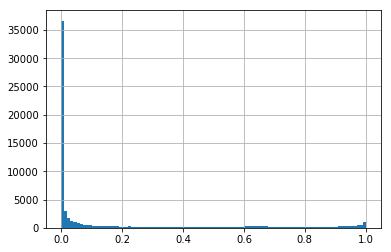

In [8]:
# Minority Class (yes) Distribution
prob_col = 'prediction_cult_prob_yes'
df[prob_col].hist(bins=100)

In [13]:
# Look at top_n most likely cases for using this perspective
top_n = 2000
threshold = calculate_threshold(top_n, df[prob_col])
num = len(df[df[prob_col] > threshold])
prop = (num/len(df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

3.029% (1980) of cases are above 0.967


### Relational perspective

In [14]:
# Show predicted labels
pred_col = 'prediction_relt'
df[pred_col].value_counts()

no     45615
yes    19750
Name: prediction_relt, dtype: int64

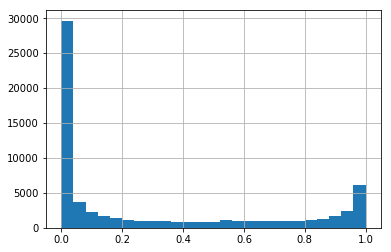

In [15]:
# Minority Class (yes) Distribution
prob_col = 'prediction_relt_prob_yes'
df[prob_col].hist(bins=25)

In [16]:
# Look at top_n most likely cases for using this perspective
top_n = 2000
threshold = calculate_threshold(top_n, df[prob_col])
num = len(df[df[prob_col] > threshold])
prop = (num/len(df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

2.924% (1911) of cases are above 0.995


### Demographic perspective

In [17]:
# Show predicted labels
pred_col = 'prediction_demog'
df[pred_col].value_counts()

no     46825
yes    18540
Name: prediction_demog, dtype: int64

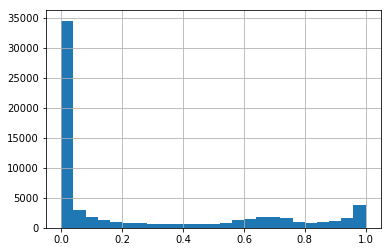

In [18]:
# Minority Class (yes) Distribution
prob_col = 'prediction_demog_prob_yes'
df[prob_col].hist(bins=25)

In [19]:
# Look at top_n most likely cases for using this perspective
top_n = 2000
threshold = calculate_threshold(top_n, df[prob_col])
num = len(df[df[prob_col] > threshold])
prop = (num/len(df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

3.041% (1988) of cases are above 0.989


### Organizational Sociology

In [20]:
# Show predicted labels
pred_col = 'prediction_orgs'
df[pred_col].value_counts()

no     55482
yes     9883
Name: prediction_orgs, dtype: int64

In [22]:
# Show predicted labels for sociology only
print(df['primary_subject'].value_counts())
df[df['primary_subject']=='Sociology'][pred_col].value_counts()

Sociology                               48047
Management & Organizational Behavior    17318
Name: primary_subject, dtype: int64


no     41078
yes     6969
Name: prediction_orgs, dtype: int64

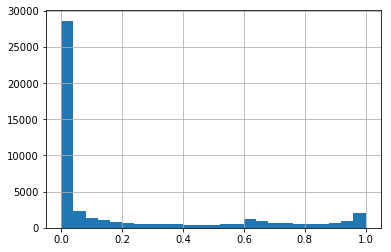

In [29]:
# Minority Class (yes) Distribution for Sociology only: Cultural
prob_col = 'prediction_cult_prob_yes'
df[df['primary_subject']=='Sociology'][prob_col].hist(bins=25)

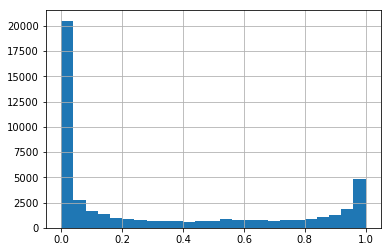

In [31]:
# Minority Class (yes) Distribution for Sociology only: Cultural
prob_col = 'prediction_relt_prob_yes'
df[df['primary_subject']=='Sociology'][prob_col].hist(bins=25)

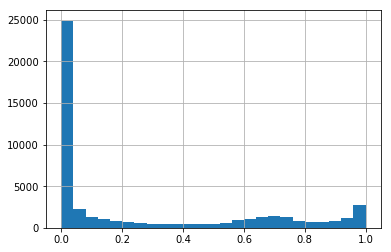

In [30]:
# Minority Class (yes) Distribution for Sociology only: Demographic
prob_col = 'prediction_demog_prob_yes'
df[df['primary_subject']=='Sociology'][prob_col].hist(bins=25)

In [24]:
# Look at top_n most likely cases for using this perspective
top_n = 2000
threshold = calculate_threshold(top_n, df[prob_col])
num = len(df[df['primary_subject']=='Sociology'][df[prob_col] > threshold])
prop = (num/len(df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

2.156% (1409) of cases are above 0.989


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


#### Filter sociology -> organizational sociology

In [58]:
minority_threshold_orgs = 0.5
df_orgsoc = df[df['primary_subject']=='Sociology'][df['prediction_orgs_prob_yes'] > minority_threshold_orgs]

print(df_orgsoc.shape)
df_orgsoc.head()

(6969, 23)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,file_name,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year,type,...,prediction_relt,prediction_relt_prob_yes,prediction_relt_prob_no,prediction_demog,prediction_demog_prob_yes,prediction_demog_prob_no,prediction_orgs,prediction_orgs_prob_yes,prediction_orgs_prob_no,file_path
2,journal-article-10.2307_2095822,10.2307_2095822,Local Friendship Ties and Community Attachment...,https://www.jstor.org/stable/2095822,This study presents a multilevel empirical tes...,American Sociological Review,"[Alice O., Peter, W. Erwin, Bert, Robert W., C...",Sociology,1983,research-article,...,yes,0.872496,0.127504,no,0.296735,0.703265,yes,0.521677,0.478323,/vol_b/data/jstor_data/ocr/journal-article-10....
8,journal-article-10.2307_24708246,10.2307_24708246,"More women, lower pay? Occupational sex compos...",https://www.jstor.org/stable/24708246,Research consistently shows that the share of ...,Acta Sociologica,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Sociology,2013,research-article,...,no,0.001928,0.998072,yes,0.967717,0.032283,yes,0.999910,0.000090,/vol_b/data/jstor_data/ocr/journal-article-10....
17,journal-article-10.2307_24048141,10.2307_24048141,Capitalizing social networks: Sri Lankan migra...,https://www.jstor.org/stable/24048141,Social capital is usually seen as a fixed asse...,Ethnography,"[Noëlle, MICHAEL, Wolf F., Eberhard K., Peter,...",Sociology,2011,research-article,...,no,0.123438,0.876562,yes,0.886777,0.113223,yes,0.987430,0.012570,/vol_b/data/jstor_data/ocr/journal-article-10....
18,journal-article-10.2307_2579310,10.2307_2579310,An Eye for an Eye? A Note on the Southern Subc...,https://www.jstor.org/stable/2579310,Efforts to explain regional variations in rate...,Social Forces,"[Yves, Jean, Megan, Thomas E., HOMER W., Mary ...",Sociology,1991,research-article,...,yes,0.998598,0.001402,no,0.000782,0.999218,yes,0.997390,0.002610,/vol_b/data/jstor_data/ocr/journal-article-10....
22,journal-article-10.2307_583974,10.2307_583974,Developing Respite Care: A Support Service for...,https://www.jstor.org/stable/583974,Respite care is identified as a temporary reli...,Family Relations,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Sociology,1978,research-article,...,no,0.001283,0.998717,yes,0.962636,0.037364,yes,0.642285,0.357715,/vol_b/data/jstor_data/ocr/journal-article-10....


## Select articles for sample

Get sample of 150 new articles (50 per perspective), composed of 90% minority class and 10% majority class.<br>
To improve fidelity of model, make the tweets selected majority class fuzzy/unreliable, so model gets better at labeling these.<br>
First, filter into new DFs, one for minority class and one for (fuzzy) majority class.

In [25]:
keepcols = ['article_name', 'abstract', 'jstor_url', 'year', 'journal_title', 'edited_filename', 'primary_subject', 
            'prediction_cult', 'prediction_cult_prob_yes',  'prediction_cult_prob_no', 
            'prediction_relt', 'prediction_relt_prob_yes', 'prediction_relt_prob_no', 
            'prediction_demog', 'prediction_demog_prob_yes', 'prediction_demog_prob_no']

### Get minority class cases

In [59]:
# set thresholds for minority cases for each myth
# set these as low as possible to capture N tweets likely to fall in minority class
capture_num = 50
minority_ratio = 0.9 # 90% from minority class

minority_threshold_cult = 0.7 #calculate_threshold(capture_num, df['prediction_cult_prob_yes'])
minority_threshold_relt = 0.8 #calculate_threshold(capture_num, df['prediction_relt_prob_yes'])
minority_threshold_demog = 0.8 #calculate_threshold(capture_num, df['prediction_demog_prob_yes'])

# filter using threshold: select articles with prob of being in minority class
df_cult_mgt_minority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_cult_prob_yes'] > minority_threshold_cult]
df_relt_mgt_minority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_relt_prob_yes'] > minority_threshold_relt]
df_demog_mgt_minority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_demog_prob_yes'] > minority_threshold_demog]

# filter using threshold: select articles with prob of being in minority class
df_cult_soc_minority = df_orgsoc[df_orgsoc['prediction_cult_prob_yes'] > minority_threshold_cult]
df_relt_soc_minority = df_orgsoc[df_orgsoc['prediction_relt_prob_yes'] > minority_threshold_relt]
df_demog_soc_minority = df_orgsoc[df_orgsoc['prediction_demog_prob_yes'] > minority_threshold_demog]

print('Number of likely cultural mgt articles above prob. threshold of {}: {}'.
      format(str(minority_threshold_cult), 
      str(len(df_cult_mgt_minority))))
print('Number of likely relational mgt articles above prob. threshold of {}: {}'.
      format(str(minority_threshold_relt), 
      str(len(df_relt_mgt_minority))))
print('Number of likely demographic mgt articles above prob. threshold of {}: {}'.
      format(str(minority_threshold_demog), 
      str(len(df_demog_mgt_minority))))
print()
print('Number of likely cultural soc articles (likely about orgs) above prob. threshold of {}: {}'.
      format(str(minority_threshold_cult), 
      str(len(df_cult_soc_minority))))
print('Number of likely relational soc articles (likely about orgs) above prob. threshold of {}: {}'.
      format(str(minority_threshold_relt), 
      str(len(df_relt_soc_minority))))
print('Number of likely demographic soc articles (likely about orgs) above prob. threshold of {}: {}'.
      format(str(minority_threshold_demog), 
      str(len(df_demog_soc_minority))))

Number of likely cultural mgt articles above prob. threshold of 0.7: 811
Number of likely relational mgt articles above prob. threshold of 0.8: 2649
Number of likely demographic mgt articles above prob. threshold of 0.8: 2212

Number of likely cultural soc articles (likely about orgs) above prob. threshold of 0.7: 1390
Number of likely relational soc articles (likely about orgs) above prob. threshold of 0.8: 2266
Number of likely demographic soc articles (likely about orgs) above prob. threshold of 0.8: 1719


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [21]:
# Save random sample of minority-class articles (to supplement full sample below)
mgt_relt_yes = df_relt_minority[
    df_relt_minority['primary_subject']=='Management & Organizational Behavior'].sample(
    n = 30, random_state = 43)[keepcols].reset_index(drop=True)
mgt_demog_yes = df_demog_minority[
    df_demog_minority['primary_subject']=='Management & Organizational Behavior'].sample(
    n = 40, random_state = 43)[keepcols].reset_index(drop=True)

# Set path and save each resulting DF to file
path = data_fp + 'sample/' + 'mgt_relt' + '_MLP_' + f'{str(30)}_{str(thisday)}'
mgt_relt_yes.to_csv(path + '.csv', index=False)

path = data_fp + 'sample/' + 'mgt_demog' + '_MLP_' + f'{str(40)}_{str(thisday)}'
mgt_demog_yes.to_csv(path + '.csv', index=False)

### Get majority class cases

In [63]:
# set thresholds for majority cases for each myth
# set these as low as possible to capture N tweets likely to fall in majority class
capture_num = 50

majority_threshold_cult = 0.2 #calculate_threshold(capture_num, df['prediction_cult_prob_yes'])
majority_threshold_relt = 0.2 #calculate_threshold(capture_num, df['prediction_relt_prob_yes'])
majority_threshold_demog = 0.2 #calculate_threshold(capture_num, df['prediction_demog_prob_yes'])

# filter using threshold: select articles with prob of being in minority class
df_cult_mgt_majority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_cult_prob_yes'] < majority_threshold_cult]
df_relt_mgt_majority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_relt_prob_yes'] < majority_threshold_relt]
df_demog_mgt_majority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_demog_prob_yes'] < majority_threshold_demog]

# filter using threshold: select articles with prob of being in minority class
df_cult_soc_majority = df_orgsoc[df_orgsoc['prediction_cult_prob_yes'] < majority_threshold_cult]
df_relt_soc_majority = df_orgsoc[df_orgsoc['prediction_relt_prob_yes'] < majority_threshold_relt]
df_demog_soc_majority = df_orgsoc[df_orgsoc['prediction_demog_prob_yes'] < majority_threshold_demog]

print('Number of likely not-cultural mgt articles below prob. threshold of {}: {}'.
      format(str(majority_threshold_cult), 
      str(len(df_cult_mgt_majority))))
print('Number of likely not-relational mgt articles below prob. threshold of {}: {}'.
      format(str(majority_threshold_relt), 
      str(len(df_relt_mgt_majority))))
print('Number of likely not-demographic mgt articles below prob. threshold of {}: {}'.
      format(str(majority_threshold_demog), 
      str(len(df_demog_mgt_majority))))
print()
print('Number of likely not-cultural soc articles (likely about orgs) below prob. threshold of {}: {}'.
      format(str(majority_threshold_cult), 
      str(len(df_cult_soc_majority))))
print('Number of likely not-relational soc articles (likely about orgs) below prob. threshold of {}: {}'.
      format(str(majority_threshold_relt), 
      str(len(df_relt_soc_majority))))
print('Number of likely not-demographic soc articles (likely about orgs) below prob. threshold of {}: {}'.
      format(str(majority_threshold_demog), 
      str(len(df_demog_soc_majority))))

Number of likely not-cultural mgt articles below prob. threshold of 0.2: 15148
Number of likely not-relational mgt articles below prob. threshold of 0.2: 11519
Number of likely not-demographic mgt articles below prob. threshold of 0.2: 11543

Number of likely not-cultural soc articles (likely about orgs) below prob. threshold of 0.2: 4192
Number of likely not-relational soc articles (likely about orgs) below prob. threshold of 0.2: 2687
Number of likely not-demographic soc articles (likely about orgs) below prob. threshold of 0.2: 3142


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


### Get cases with fuzzy predictions

In [64]:
def check_pred_fuzzy(row, 
                     pred_labels = ['yes', 'no'], 
                     myth_labels = ['cult', 'relt', 'demog'],
                     upper_threshold=0.5, 
                     lower_threshold=0.1):
    
    '''
    Checks whether prediction is fuzzy/unreliable. Use this to determine if a tweet is worth hand-coding.
    Rationale: by only coding tweets with unreliable labels, we can improve the classifier's ability to detect 'unsure' cases.
    
    Function focuses on this difference: prob(predicted label) - prob(some other label).
    If difference is greater than lower_threshold (minimum for hand-coding of tweet to be possible), 
    but lesser than upper_threshold (maximum for hand-coding to be necessary), then it IS worth coding, so return True. 
    If difference is not between these, then we either it can't be reliably coded, or already have a reliable prediction,
    so we don't need to hand-code --> return False.

    To help select a threshold, ask: To what extent do we want the uncertainty to be, to help inform our sample selection?    
    For example, if a tweet is labeled as POS with 90% prob and NEG 10% --> this is very obvious sample, so don't bother coding.
    On the other hand, if the predictions are 51% NEG and 49 POS, then we need ppl to label this to update our model. 
    If our upper_threshold is 20% (0.20), then if a tweet has 61% NEG 39% POS probabilities, we don't choose it. 
    If some other tweet has prob 59% POS 41% NEG, we do select it for coding.
    
    Args:
        row: row corresponding to tweet, with predictions in format...
        pred_labels: labels for probabilities to use--used for naming columns
        myth_labels: labels for COVID-19 myths to detect--used for naming columns
        upper_threshold: max difference between predicted probs
        lower_threshold: min difference between predicted probs
    
    Returns:
        Array: True if tweet should be hand-coded, otherwise False. Array contains determinations for all myths
    '''
    
    worth_coding = []
    
    for myth in myth_labels:
        pred_label = row[f'prediction_{myth}'].strip() # get label of prediction for tweet--must be one of those in possible_labels!
        pred_score = float(row[f'prediction_{myth}_prob_{pred_label}']) # get probability of predicted label (probably high)
        
        for pred in pred_labels: # Look at each label
            pred = pred.strip() # clean label text
            
            if pred != pred_label: # if this label isn't the predicted one...
                difference = pred_score - float(row[f'prediction_{myth}_prob_{pred}']) # ...then look at their difference in probability
                if lower_threshold <= difference <= upper_threshold:
                 # if difference in probs is > lower_threshold but < upper_threshold, then pred is fuzzy and we should code
                    worth_coding.append(True) # worth coding
                
                else: worth_coding.append(False)
                    
    if len(worth_coding) == 1:
        return worth_coding[0]
    
    else: return worth_coding

In [65]:
# Get fuzzy categories for management/OB
df_cult_mgt_fuzzy = df[df['primary_subject']=='Management & Organizational Behavior'][df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['cult'], 
                                                                                                                                  lower_threshold = 0.1, upper_threshold = .2), axis=1)]      
df_relt_mgt_fuzzy = df[df['primary_subject']=='Management & Organizational Behavior'][df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['relt'], 
                                                                                                                                  lower_threshold = 0.1, upper_threshold = .2), axis=1)]
df_demog_mgt_fuzzy = df[df['primary_subject']=='Management & Organizational Behavior'][df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['demog'], 
                                                                                                                                   lower_threshold = 0.1, upper_threshold = .2), axis=1)]

print(f'Number of fuzzy predictions for cultural mgt: {df_cult_mgt_fuzzy.shape}')
print(f'Number of fuzzy predictions for relational mgt: {df_relt_mgt_fuzzy.shape}')
print(f'Number of fuzzy predictions for demographic mgt: {df_demog_mgt_fuzzy.shape}')

100%|██████████| 65365/65365 [00:02<00:00, 28397.91it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 65365/65365 [00:02<00:00, 29462.99it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
100%|██████████| 65365/65365 [00:02<00:00, 29422.88it/s]

Number of fuzzy predictions for cultural mgt: (233, 23)
Number of fuzzy predictions for relational mgt: (498, 23)
Number of fuzzy predictions for demographic mgt: (507, 23)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [66]:
# Get fuzzy categories for Sociology
df_cult_soc_fuzzy = df_orgsoc[df_orgsoc.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['cult'], 
                                                                                  lower_threshold = 0.1, upper_threshold = .2), axis=1)]      
df_relt_soc_fuzzy = df_orgsoc[df_orgsoc.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['relt'], 
                                                                                 lower_threshold = 0.1, upper_threshold = .2), axis=1)]
df_demog_soc_fuzzy = df_orgsoc[df_orgsoc.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['demog'], 
                                                                                  lower_threshold = 0.1, upper_threshold = .2), axis=1)]

print(f'Number of fuzzy predictions for cultural soc: {df_cult_soc_fuzzy.shape}')
print(f'Number of fuzzy predictions for relational soc: {df_relt_soc_fuzzy.shape}')
print(f'Number of fuzzy predictions for demographic soc: {df_demog_soc_fuzzy.shape}')

100%|██████████| 6969/6969 [00:00<00:00, 29586.80it/s]

Number of fuzzy predictions for cultural soc: (234, 23)
Number of fuzzy predictions for relational soc: (389, 23)
Number of fuzzy predictions for demographic soc: (280, 23)


## Compile sample

In [74]:
def stratified_sample_df(df, col, n_samples):
    '''Get random sample of n_samples from df weighted/stratified by col.
    Source: https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas'''
    
    n = min(n_samples, df[col].value_counts().min()) # determine number of rows by lowest n per group in col
    df_sampled = df.groupby(col).apply(lambda x: x.sample(n)) # randomly sample n rows from each group
    
    # Ensure we only get desired sample size
    if len(df_sampled) > n_samples:
        df_sampled = df_sampled.sample(n = n_samples)
    
    df_sampled.index = df_sampled.index.droplevel(0) # drop index
    
    return df_sampled

In [80]:
def sample_rows_weighted(df, 
                         df_minority, 
                         df_majority, 
                         df_fuzzy, 
                         sample_size=50, 
                         prop_min = 0.4, 
                         prop_maj = 0.2, 
                         prop_fuzzy = 0.4, 
                         stratify_cols = []):
    '''
    Samples from DF using data objects computed above: minority DF (likely to be in minority class), 
    majority DF (likely in majority class), and fuzzy DF (uncertain to be in majority class).
    Stratifies the sample using columns passed in. When necessary, 
    supplements stratified sampling with random sampling to reach desired sample size.
    
    Args:
        df (DataFrame): original df with id and full text
        df_minority (DataFrame): DF with cases from minority class (with rows above threshold, computed above)
        df_majority (DataFrame): DF with cases from majority class (with rows below threshold, computed above)
        df_fuzzy (DataFrame): DF with cases not certainly classified (with rows between thresholds, computed above)
        sample_size (int): number of total rows to sample
        prop_min (float): proportion of total rows to be minority label
        prop_maj (float): proportion of total rows to be majority label
        prop_fuzzy (float): proportion of total rows to be fuzzy predictions
        stratify_cols (list): columns of DF to use for sample stratification/weighting, from last to first
        
    Returns:
        DataFrame: combined samples
    '''
    
    df_sample = pd.DataFrame() # initialize final sample DF
    fnames = [] # initialize list of articles (file names) to sample
    
    # Weighted sampling prep
    min_size = int(prop_min*sample_size) # number of rows to gather from df_minority
    maj_size = int(prop_maj*sample_size) # number of rows to gather from df_majority
    fuzzy_size = int(prop_fuzzy*sample_size) # number of rows to gather from df_fuzzy
    
    minority_sample_each = int(min_size/len(stratify_cols)) # number to sample for each loop of stratified sampling from df_minority
    majority_sample_each = int(maj_size/len(stratify_cols)) # number to sample for each loop of stratified sampling from df_majority
    fuzzy_sample_each = int(fuzzy_size/len(stratify_cols)) # number to sample for each loop of stratified sampling from df_majority
    
    # Get random sample of minority cases
    for col in stratify_cols:
        num_samples = 0 # placeholder for number cases sampled
        
        # Minority sample
        names_temp = stratified_sample_df(
            df_minority, 
            col = col, 
            n_samples = minority_sample_each)['file_name']
        fnames.extend(names_temp); num_samples += len(names_temp)
        #if len(names_temp) < minority_sample_each:
        #    diff = len(names_temp) - minority_sample_each
        #    new = df_minority.sample(n = diff)
        #    fnames.extend(new); num_samples += len(new)
            
        # Majority sample
        names_temp = stratified_sample_df(
            df_majority, 
            col = col, 
            n_samples = majority_sample_each)['file_name']
        fnames.extend(names_temp); num_samples += len(names_temp)
        #if len(names_temp) < majority_sample_each:
        #    diff = len(names_temp) - majority_sample_each
        #    new = df_majority.sample(n = diff)
        #    fnames.extend(new); num_samples += len(new)
        
        # Fuzzy sample
        names_temp = stratified_sample_df(
            df_fuzzy, 
            col = col, 
            n_samples = fuzzy_sample_each)['file_name']
        fnames.extend(names_temp); num_samples += len(names_temp)
        #if len(names_temp) < fuzzy_sample_each:
        #    diff = len(names_temp) - fuzzy_sample_each
        #    new = df_fuzzy.sample(n = diff)
        #    fnames.extend(new); num_samples += len(new)
        
        #print(f'Gathered {str(num_samples)} for {col}, expected {str(sample_size/len(stratify_cols))}')
        
    for fname in tqdm(fnames, desc="Merging samples"):
        df_sample = df_sample.append(df.loc[df['file_name'] == fname],ignore_index=True)
    #for id in tqdm(df_fuzzy['id'].sample(n=maj_size)):
    #    df_sample = df_sample.append(df.loc[df['id'] == id][['id','created_at','full_text']],ignore_index=True)
    
    #df_sample = df_sample.sample(n = sample_size, random_state = 43).reset_index(drop=True) # finalize sample of size = sample_size
    
    print(f'Returning weighted sample DF of {len(df_sample)} rows, asked for {sample_size} rows.')
    
    return df_sample

### Sociology sample

In [83]:
print('Number of cases selected from Organizational Sociology:')

cult_soc_sample = sample_rows_weighted(df_orgsoc,
                                   df_cult_soc_minority, 
                                   df_cult_soc_majority, 
                                   df_cult_soc_fuzzy, 
                                   sample_size = n_sample, 
                                   prop_min = 0.4, 
                                   prop_maj = 0.4, 
                                   prop_fuzzy = 0.2, 
                                   stratify_cols = ['journal_title', 'year'])[keepcols]
                          
relt_soc_sample = sample_rows_weighted(df_orgsoc,
                                   df_relt_soc_minority, 
                                   df_relt_soc_majority, 
                                   df_relt_soc_fuzzy, 
                                   sample_size = n_sample, 
                                   prop_min = 0.4, 
                                   prop_maj = 0.4, 
                                   prop_fuzzy = 0.2,
                                   stratify_cols = ['journal_title', 'year'])[keepcols]

demog_soc_sample = sample_rows_weighted(df_orgsoc,
                                    df_demog_soc_minority, 
                                    df_demog_soc_majority, 
                                    df_demog_soc_fuzzy, 
                                    sample_size = n_sample, 
                                    prop_min = 0.4, 
                                    prop_maj = 0.4, 
                                    prop_fuzzy = 0.2,
                                    stratify_cols = ['journal_title', 'year'])[keepcols]

Number of cases selected from Organizational Sociology:


Merging samples: 100%|██████████| 50/50 [00:00<00:00, 175.61it/s]


Returning sample DF of 50 rows, asked for 50 rows.


Merging samples: 100%|██████████| 50/50 [00:00<00:00, 173.80it/s]


Returning sample DF of 50 rows, asked for 50 rows.


Merging samples: 100%|██████████| 50/50 [00:00<00:00, 169.55it/s]

Returning sample DF of 50 rows, asked for 50 rows.


### Management/OB sample

In [85]:
print('Number of cases selected from Management/OB:')

cult_mgt_sample = sample_rows_weighted(df[df['primary_subject']=='Management & Organizational Behavior'],
                                   df_cult_mgt_minority, 
                                   df_cult_mgt_majority, 
                                   df_cult_mgt_fuzzy, 
                                   sample_size = n_sample, 
                                   prop_min = 0.4, 
                                   prop_maj = 0.4, 
                                   prop_fuzzy = 0.2, 
                                   stratify_cols = ['journal_title', 'year'])[keepcols]
                          
relt_mgt_sample = sample_rows_weighted(df[df['primary_subject']=='Management & Organizational Behavior'],
                                   df_relt_mgt_minority, 
                                   df_relt_mgt_majority, 
                                   df_relt_mgt_fuzzy, 
                                   sample_size = n_sample, 
                                   prop_min = 0.4, 
                                   prop_maj = 0.4, 
                                   prop_fuzzy = 0.2,
                                   stratify_cols = ['journal_title', 'year'])[keepcols]

demog_mgt_sample = sample_rows_weighted(df[df['primary_subject']=='Management & Organizational Behavior'],
                                    df_demog_mgt_minority, 
                                    df_demog_mgt_majority, 
                                    df_demog_mgt_fuzzy, 
                                    sample_size = n_sample, 
                                    prop_min = 0.4, 
                                    prop_maj = 0.4, 
                                    prop_fuzzy = 0.2,
                                    stratify_cols = ['journal_title', 'year'])[keepcols]

Number of cases selected from Management/OB:


Merging samples: 100%|██████████| 50/50 [00:00<00:00, 149.68it/s]


Returning sample DF of 50 rows, asked for 50 rows.


Merging samples: 100%|██████████| 50/50 [00:00<00:00, 153.80it/s]


Returning sample DF of 50 rows, asked for 50 rows.


Merging samples: 100%|██████████| 50/50 [00:00<00:00, 152.58it/s]

Returning sample DF of 50 rows, asked for 50 rows.


### Check date distribution

Text(0, 0.5, 'count')

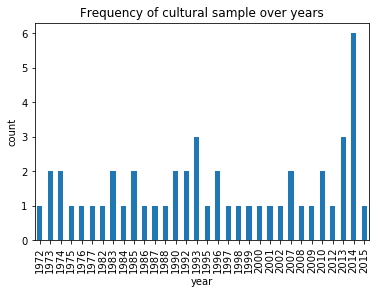

In [86]:
cult_plot = cult_soc_sample.groupby('year').size()\
        .plot(kind='bar',title='Frequency of cultural sample over years')
cult_plot.set_ylabel('count')

Text(0, 0.5, 'count')

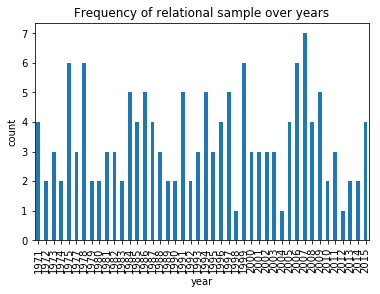

In [169]:
relt_plot = relt_sample.groupby('year').size()\
        .plot(kind='bar',title='Frequency of relational sample over years')
relt_plot.set_ylabel('count')

Text(0, 0.5, 'count')

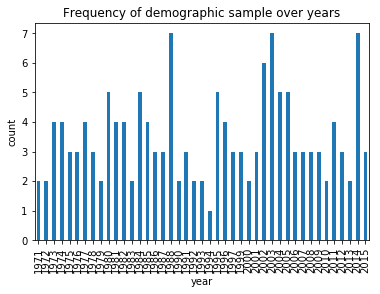

In [170]:
demog_plot = cult_sample.groupby('year').size()\
        .plot(kind='bar',title='Frequency of demographic sample over years')
demog_plot.set_ylabel('count')

## Save to file

In [178]:
# Save random samples in .csv format
for dframe, name in list(zip([relt_soc_sample, demog_soc_sample, cult_soc_sample, 
                              relt_mgt_sample, demog_mgt_sample, cult_mgt_sample], 
                             ['soc_relt', 'soc_demog', 'soc_cult', 'mgt_relt', 'mgt_demog', 'mgt_cult'])):
    
    # Add new, empty first columns to use for manual coding of engagement, notes, and whether uses some other perspective 
    col1 = "stance twd. " + str(name[4:]) + " persp. (1: positive; 0.5: maybe; 0: none)" # name of column to be first in DF
    col2 = "notes"
    col3 = "other persp.?"
    
    for col in [col3, col2, col1]: # To get final order right, loop over new cols in reverse order: 3rd col, then 2nd, then 1st
        dframe[col] = "" # create empty column
        popcol = dframe.pop(col) # extract empty column
        dframe.insert(0, col, popcol) # put empty column in beginning
    
    # Save each resulting DF to file
    path = data_fp + 'sample/' + name + '_MLP_' + f'{str(n_sample)}_{str(thisday)}'
    dframe.to_csv(path + '.csv', index=False)
    #var.to_excel(path + '.xlsx')